# Regression in Pytorch

In the previous lab, we have seen the basics of Pytorch and how to manipulate data through datasets and dataloaders. However, the strength of Pytorch is its ability to define and train _models_. In this lab, we see how to do that for regression tasks.

## Preliminaries (course reminder)

A model is basically a mapping (=a mathematical function $f$) between inputs $x$ and outputs $y$, such that $ y \approx f(x)$. For instance, in age dection, the input data $x$ is the set of pixel values of a person's photo, and the output is the number $y$ corresponding to the age of that person.

<center><a href="https://pyimagesearch.com/2020/04/13/opencv-age-detection-with-deep-learning/">
    <img src="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2020/04/opencv_age_detection_examples.jpg?lossy=1&strip=1&webp=1" width="550"></a></center>
    
To perform such a task, we have to:

- Design a model $f$, that is, we specify a general mathematical function (e.g., a neural network) with some parameters (either a few or millions).
- Train $f$ using a dataset of known image/age pairs (a _training dataset_) in order to adjust the parameters of the model. We do that by considering an _optimization_ problem: ideally, we want the predicted age $y_{\text{pred}} = f(x)$ to be as close as possible to the true age $y$. Therefore, we define a _loss function_ which measures the difference between $y$ and $y_{\text{pred}}$, and we want adjust the parameters of the model $f$ such that they minimize this loss function. This is achieved by using an optimization algorithm such as stochastic gradient descent, which is directly implemented in Pytorch.

Once the model is designed and trained, we can use it for performing predictions on novel data.

Broadly speaking, there are basically two types of tasks in machine learning, depending on the nature of the output $y$:

- if $y$ can take only a finite number of values (usually represented as integers), then it's a _classification_ task. The most basic case is when there are only two possible classes (binary classification). Examples are hate speech detection (1 = hate, 0 = no hate), recommender systems (1 = like, 0 = dislike), spam detection (1 = spam, 0 = not spam), etc.
- if $y$ ranges in a continuous (and therefore infinite) set of values, then it's a _regression_ task. Examples are age prediction as above ($y \in [0, 100]$, or any arbitrary high value), estimating the price of a product, weather forecast, etc.

We will study classification in the next lab. In this one, we focus on regression, and we consider generic numerical data $x$ and $y$. But before diving into regression, let's learn a bit about the Autograd module.


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Automatic differentiation (Autograd)

Autograd is the Pytorch engine that performs gradient tracking and computation. It really is the core of neural networks training, since optimization algorithms like stochastic gradient descent rely on gradient computation. Every tensor in Pytorch not only contains some values (the data itself), but also stores the gradients related to operations that have been computed using these tensors.


In [2]:
# By default, when tensors are created their gradients is not tracked
x = torch.ones(1, 10)
print(x.requires_grad)

False


In [3]:
# You can change it using the requires_grad_() method
x.requires_grad_()
print(x.requires_grad)

# Alternatively, when creating a tensor, you can directly set 'requires_grad=True'
x = torch.ones(1, 10, requires_grad=True)
print(x.requires_grad)

True
True


In [4]:
# You can access the gradient stored in x with 'x.grad'.
# However, since no computation has been performed yet, it should return 'None'
print(x.grad)

None


In [5]:
# If you create a tensor y from x using any torch operation, it will have a gradient function (grad_fn) which is specific to this operation
y = x + 50
print(y.grad_fn)

y = 3 * x
print(y.grad_fn)

y = x.mean()
print(y.grad_fn)

As an example, let's define an operation involving a 1D data tensor $\mathbf{x} = [x_0, \ldots, x_{9}]$ and a parameter $a$:

$$ loss = a \times \sum_i x_i $$

We can mathematically compute the gradient of $loss$ with respect to $a$ and $\mathbf{x}$:

$$ \nabla*{a} loss = \sum_i x_i $$
and
$$ \nabla*{x*i} loss = a \quad (\text{or in vector form:} \quad \nabla*{\mathbf{x}} loss = [a, \ldots, a]) $$

Of course, on this example it's easy to compute gradients by hand. But when working with deep neural networks with millions of parameters, it can be a bit more complicated. The good news is that Pytorch does it automatically for us, thanks to the `backward()` method.


In [6]:
# Let's implement the above:
a = torch.tensor(
    [3], requires_grad=True, dtype=torch.float
)  # specify float as the data type, otherwise it can't compute gradients
x = torch.ones(1, 10, requires_grad=True)

loss = x.sum() * a
print(loss.requires_grad)

# Now, let's compute the gradient of the loss with respect to x and a
loss.backward()

# These gradients are stored in x.grad and a.grad
print(x.grad)
print(a.grad)

True
tensor([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])
tensor([10.])


**Note**: When we create a Pytorch model using `torch.nn` modules (we'll see that later on), the corresponding parameters have `requires_grad=True` by default. It makes sense since these parameters are exactly what we want to optimize (therefore we need to compute their gradients). However, in general we do not need to compute the gradient with respect to the data (input $x$ and/or output $y$), since these are fixed. In the example above, we computed the gradient with respect to `x` purely for illustrative purpose.


In [7]:
# After a model is trained, we no longer need to compute its gradient. Therefore, when doing prediction,
# we can disable gradient tracking to save memory and computational time

with torch.no_grad():
    loss = x.sum() * a
    print(loss.requires_grad)

False


In [8]:
# TO DO:
# - define a data tensors x which simply contains the value 2
x = torch.tensor([2])

# - define another data tensor y which simply contains the value 10
y = torch.tensor([10])

# - define parameter tensors w and b with values 1 and 3, respectively (these need gradient tracking)
w = torch.tensor([1], requires_grad=True, dtype=torch.float)
b = torch.tensor([3], requires_grad=True, dtype=torch.float)

# - compute the loss as: loss=(y - (w*x + b))^2
loss = (y - (w * x + b)) ** 2

# - compute the gradients of loss
loss.backward()

# - print the value of the gradient of loss with respect to w and b
print(w.grad)
print(b.grad)

# hint: to be sure there's no mistake, you can check if it's correct with a bit of math.


tensor([-20.])
tensor([-10.])


<span style="color:red">**Q1**</span> Put the values of these gradients in your report.

## Linear regression

<center><a href="https://kpu.pressbooks.pub/learningstatistics/chapter/linear-regression/">
    <img src="https://kpu.pressbooks.pub/app/uploads/sites/66/2019/09/regression1a-1.png" width="500"></a></center>

Let's now address linear regression. Assuming we have several points of data pairs $(x,y)$, the model is simply $f(x) = wx + b$, where $w$ is called _weight_ (or slope) and $b$ is called the _bias_. The goal of linear regression is to estimate the optimal $w$ and $b$ from the available training data $x$ and $y$.

**Note**: we don't really need Pytorch for solving that problem (indeed, a basic gradient descent algorithm can be implemented directly without too much hassle - if you have some math background and want to have fun, please feel free). Nonetheless, we consider it anyway because it's a good basic exercice, and once linear regression is solved, we can move to more sophisticated nonlinear regression and to (deep) neural networks.

### Data


torch.Size([15, 1]) torch.Size([15, 1])


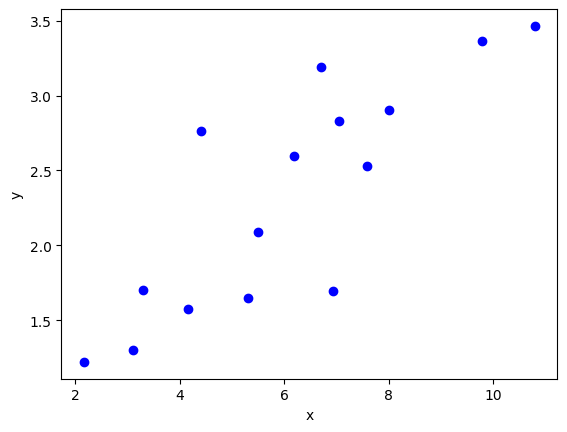

In [9]:
# Create a toy dataset
x = torch.tensor(
    [
        [3.3],
        [4.4],
        [5.5],
        [6.71],
        [6.93],
        [4.168],
        [9.779],
        [6.182],
        [7.59],
        [2.167],
        [7.042],
        [10.791],
        [5.313],
        [7.997],
        [3.1],
    ],
    dtype=torch.float,
)
y = torch.tensor(
    [
        [1.7],
        [2.76],
        [2.09],
        [3.19],
        [1.694],
        [1.573],
        [3.366],
        [2.596],
        [2.53],
        [1.221],
        [2.827],
        [3.465],
        [1.65],
        [2.904],
        [1.3],
    ],
    dtype=torch.float,
)
print(x.shape, y.shape)

# Plot the data (y as a function of x)
plt.figure()
plt.plot(x, y, "bo")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

**Note**: the data tensors `x` and `y` we have defined here constitute our _dataset_. Each data sample $(x,y)$ is actually one element in `(x,y)`. Therefore, we have one dataset of length 15, where each element ($x$ or $y$) has dimension 1. In other words, our dataset only consists of 1 batch, and the batch size if 15.

### Model

Let us create our linear model. In pytorch, it's easily done with `nn.Linear` (check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=torch%20nn%20linear#torch.nn.Linear)!). In particular, we need to specify the input and output sizes. In our case, these are equal to 1 since we work with scalars. There is also an option `bias` which can be `True` (default) or `False`. If `bias=False`, then $b=0$ and the model reduces to $f(x) = wx$.


In [10]:
# Create the linear model
input_size = 1
output_size = 1
lin_reg_model = nn.Linear(input_size, output_size, bias=True)

# 'lin_reg_model' is a module which contains the linear function and its parameters (weight and bias)
# When we instanciate the model, the parameters are initialized with random values
# We also remark that both parameters have 'requires_grad=True', which is the normal default behavior.
print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[0.2846]], requires_grad=True)
Parameter containing:
tensor([-0.2314], requires_grad=True)


True
False


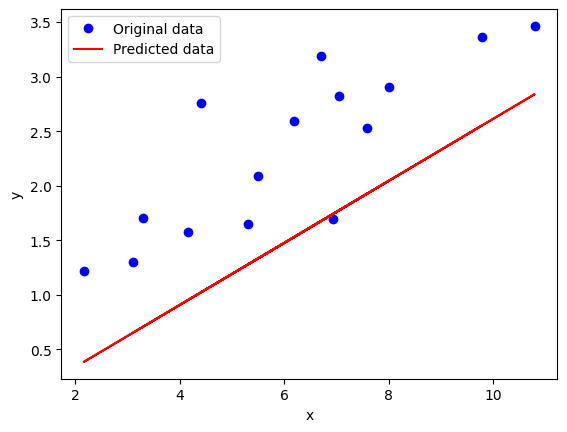

In [11]:
# Now we can compute predictions as y_pred = f(x) simply as follows:
y_pred = lin_reg_model(x)

# Since y_pred is computed from the model (which has requires_grad=True), then it also has requires_grad=True
print(y_pred.requires_grad)

# If we want to plot y_pred, we first need to get rid of its gradient (because by default it's tracked).
# This is done as follows:
y_pred = y_pred.detach()
print(y_pred.requires_grad)

# We can plot the predicted values on top of the original data
plt.figure()
plt.plot(x, y, "bo", label="Original data")
plt.plot(x, y_pred, "r", label="Predicted data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [12]:
# It is possible to manually change the values of the parameters (weight and bias):
lin_reg_model.weight.data.fill_(2)
lin_reg_model.bias.data.fill_(3)

print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[2.]], requires_grad=True)
Parameter containing:
tensor([3.], requires_grad=True)


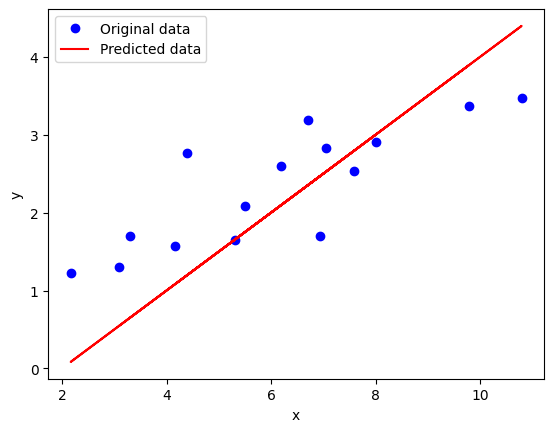

In [13]:
# TO DO:
# - set the weight and bias of the linear model at 0.5 and -1, respectively.
lin_reg_model.weight.data.fill_(0.5)
lin_reg_model.bias.data.fill_(-1)

# - compute the new predictions y_pred with this model
y_pred = lin_reg_model(x)

# - plot the predictions on top of the original data
# We can plot the predicted values on top of the original data
y_pred = y_pred.detach()

plt.figure()
plt.plot(x, y, "bo", label="Original data")
plt.plot(x, y_pred, "r", label="Predicted data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Training

Now that our model is defined, we have to train it, that is, to optimize the values of $a$ and $b$. To do that, we first define the [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and the optimizer (i.e., [the optimization algorithm](https://pytorch.org/docs/stable/optim.html#algorithms)).


In [14]:
# TO DO: first, re-instanciate the model and set both the weight and bias at 1.
# This will avoid random values and ensure reproducibility (everyone should get the same results)
lin_reg_model = nn.Linear(input_size, output_size, bias=True)

lin_reg_model.weight.data.fill_(1)
lin_reg_model.bias.data.fill_(1)

print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[1.]], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)


In [15]:
# For linear regression, it is common to use the mean square error (MSE) as loss function
loss_fn = nn.MSELoss()

# For the optimizer, let's use stochastic gradient (SGD). In Pytorch, we need to specify:
# - which parameters are going to be updated (in this case, it's the parameters of our model)
# - the learning rate
optimizer = torch.optim.SGD(lin_reg_model.parameters(), lr=0.01)

Let us illustrate what happens when the loss function is noted $\mathcal{L}$ and the optimization algorithm is a (stochastic) gradient descent (with a parameter $\mu$ called _learning rate_). The process of _training_ is an iterative procedure, where at each iteration (or _epoch_), we perform the following operations:

1. Using the current model's parameters, compute the predictions: $y_{\text{pred}} = f(x)$
2. Using the loss function, compute the error between true values and predictions: $l = \mathcal{L}(y_{\text{pred}},y)$
3. Compute the gradients of the loss with respect to the parameters. If there are only two parameters $w$ and $b$, then we have to compute $\nabla_{w} l$ and $\nabla_{b} l$.
4. Perform gradient descent, that is, update the parameters with: $w \leftarrow w - \mu \nabla_{w} l$ and $b \leftarrow b - \mu \nabla_{b} l$

The good news is that we don't have to explicitly code steps 3. and 4., since Pytorch takes care about that for us with simple functions: all gradients are computed with `l.backward()` (we have seen this one already) and the gradient descent is simply performed with `optimizer.step()`.

**Note**: before computing the gradients with `l.backward()`, it's safer to remove all possible gradients that have been computed beforehand (e.g., from another model, or loaded in the memory) to avoid numerical issues. This is easily done with: `optimizer.zero_grad()`.


In [16]:
# TO DO: Write the training loop for 10 epochs.
# At the end of each epoch, print the value of the loss (it's easily accessed with 'l.item()')
for epoch in range(10):
    y_pred = lin_reg_model(x)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(loss.item())

25.676067352294922
0.6435868144035339
0.18030418455600739
0.17171698808670044
0.17154482007026672
0.17152836918830872
0.17151494324207306
0.17150162160396576
0.17148835957050323
0.1714751422405243


In [17]:
# After training, save the parameters of the trained model and display them
torch.save(lin_reg_model.state_dict(), "model_linear_regression.pt")
print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[0.2400]], requires_grad=True)
Parameter containing:
tensor([0.8871], requires_grad=True)


<span style="color:red">**Q2**</span> What are the final values (i.e., after training) of the weight $w$ and bias $b$?


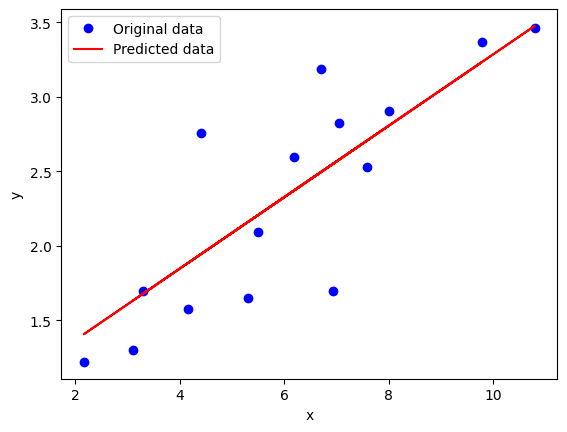

In [18]:
# TO DO: Compute the final estimates y_pred with the trained model, and display the results (predictions and original)
y_pred = lin_reg_model(x)
y_pred = y_pred.detach()

plt.figure()
plt.plot(x, y, "bo", label="Original data")
plt.plot(x, y_pred, "r", label="Predicted data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Nonlinear regression

Let us now consider a more elaborate nonlinear regression model, for which we design our first neural network. In nonlinear regression, $f$ is no longer a simple linear/affine function, but something more complicated, or something that we don't really know.

<center><a href="https://www.r-bloggers.com/2016/02/first-steps-with-non-linear-regression-in-r/">
    <img src="https://i0.wp.com/datascienceplus.com/wp-content/uploads/2016/02/NLS_2.png" width="400"></a></center>

### Data

We now consider sinusoidal-like data.


torch.Size([60])


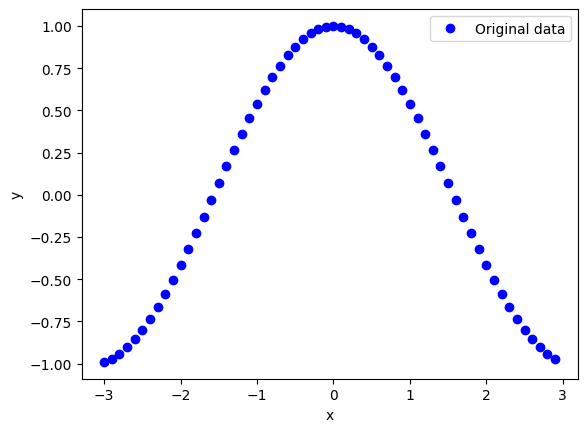

In [19]:
# TO DO: generate sinusoidal data:
# - create a tensor x which ranges from -3 to 3 with a step of 0.1
x = torch.arange(-3, 3, 0.1)
print(x.shape)

# - unsqueeze x to add an extra dimension (its shape should be [60, 1])
x = torch.unsqueeze(x, 1)

# - compute y = cos(x)
y = torch.cos(x)

# - plot y as a function of x
plt.plot(x, y, "bo", label="Original data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Model

A basic idea behind neural networks is to assemble simple layers to approximate a potentially complicated function. For instance, in multilayer perceptrons (MLP), a network is designed by concatenating several layers, where each layer consists of:

- a linear function
- and potentially a non-linear element-wise activation function

There is a plethora of nonlinear activation function, which you can check [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). A popular one is the rectified linear unit ([ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)).

Here, we propose to approximate our sinusoidal data with a simple network made up with 2 linear layers and 1 activation function in between:

$x \to$ Linear_1 $\to$ ReLU $\to$ Linear_2 $\to y$


In [20]:
# To DO: write the 'nonlin_reg_model' model.
# - the first linear layer should have input_size=1 and output_size=3 (we increase the dimension of x)
first_layer = nn.Linear(in_features=1, out_features=3, bias=True)

# - the second linear layer should have input_size=3 and output_size=1 (we go back to the dimension y)
second_layer = nn.Linear(in_features=3, out_features=1, bias=True)

# - to build the complete model, you can stack the separate layers together into one model using torch.nn.Sequential (check the doc!)
nonlin_reg_model = nn.Sequential(
    first_layer,
    nn.ReLU(),
    second_layer,
)

# - once it's done, compute nonlin_reg_model(x) to be sure there are no bugs
y_pred = nonlin_reg_model(x)

In [21]:
# initialization (ensure reproducibility: everybody should have the same results)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)


torch.manual_seed(0)
nonlin_reg_model.apply(init_weights)

Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)

### Training


In [22]:
# TO DO: write the training loop (it's very similar to the linear regression procedure) and save the trained model's parameters
# - loss function: MSE
# - number of epochs: 50
# - optimizer: SGD with a learning rate of 0.1
# Remember to record the loss over epochs.

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(nonlin_reg_model.parameters(), lr=0.1)

loss_records = []

# Training loop
for epoch in range(50):
    y_pred = nonlin_reg_model(x)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(loss.item())
    loss_records.append(loss.item())

torch.save(nonlin_reg_model.state_dict(), "model_non_linear_regression.pt")

0.8169981837272644
0.45279067754745483
0.3724183440208435
0.3247685134410858
0.2903457283973694
0.2638123333454132
0.24239791929721832
0.22399969398975372
0.2077016681432724
0.19311842322349548
0.17986874282360077
0.16754452884197235
0.15600129961967468
0.14515922963619232
0.13514158129692078
0.12570978701114655
0.11683384329080582
0.10849329084157944
0.10066947340965271
0.09334350377321243
0.08649560809135437
0.08010505139827728
0.0741504356265068
0.06860988587141037
0.06346539407968521
0.058731261640787125
0.05433952808380127
0.050267960876226425
0.04649707302451134
0.04300813376903534
0.03978307172656059
0.03680459037423134
0.03405614197254181
0.0315309539437294
0.02921387553215027
0.027080444619059563
0.02511703222990036
0.023311013355851173
0.021650608628988266
0.020124824717640877
0.01872340962290764
0.01743680238723755
0.01625608652830124
0.01517297700047493
0.01417977549135685
0.01326932106167078
0.012434999458491802
0.011670665815472603
0.010970639064908028
0.01032967213541269

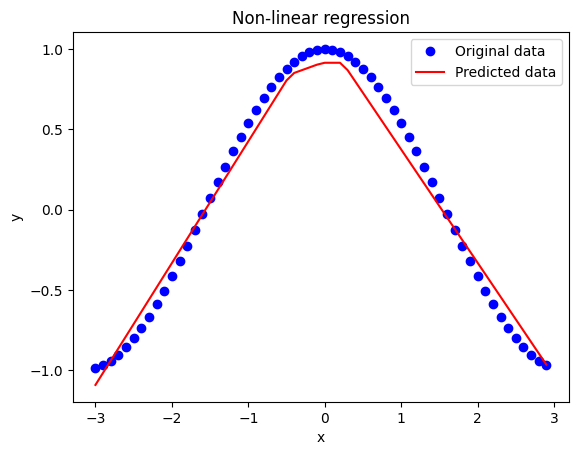

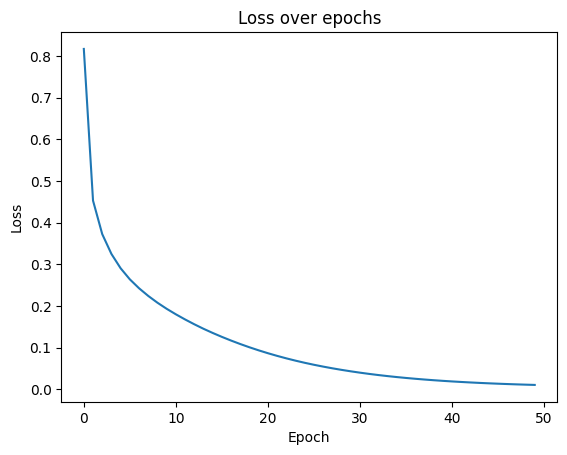

In [26]:
# TO DO: Compute the predicted outputs, and plot the results (original data and predictions)
y_pred = nonlin_reg_model(x)

y_pred = y_pred.detach()
plt.figure()
plt.plot(x, y, "bo", label="Original data")
plt.plot(x, y_pred, "r", label="Predicted data")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Non-linear regression")
plt.legend()
plt.show()

# Plot the loss over epochs
plt.plot(loss_records)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.show()

<span style="color:red">**Q3 and Q4**</span> Put the above-mentionned plots in your report (loss over epochs and original/predicted data).
